In [119]:
# This code implements an adversarial network that uses coordinate information and a normalized cross-correlation loss

In [120]:
!date

Mon Jul 28 05:39:02 PM EDT 2025


In [121]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [122]:
!echo ${0}

/bin/bash


In [123]:
!which python

~/anaconda3/bin/python


In [124]:
!nvidia-smi

Mon Jul 28 17:39:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:C9:00.0 Off |                  Off |
| N/A   32C    P0             82W /  350W |    2975MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [125]:
%%time
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel.processing as nibp
from scipy import signal
from itertools import combinations_with_replacement
from numpy import savetxt
import nibabel as nib
import math
from numpy import random
import sklearn.preprocessing  
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import List, Callable, Union, Any, TypeVar, Tuple
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn import linear_model
import sys
from IPython import display
from datetime import datetime
from sklearn.mixture import GaussianMixture


CPU times: user 97 µs, sys: 26 µs, total: 123 µs
Wall time: 125 µs


In [126]:
print(torch.__file__)
print(torch.__version__)

/home/aglinska/anaconda3/lib/python3.8/site-packages/torch/__init__.py
2.4.1+cu121


In [127]:
torch.version.cuda

'12.1'

In [128]:
torch.cuda.is_available()

True

In [129]:
torch.cuda.get_device_name(0)

'NVIDIA L40S'

In [130]:
# !pip install tqdm

In [131]:
import pickle
def load_pickle(filename):
    with open(filename,"rb") as filehandler:
        dump = pickle.load(filehandler)
    return dump

In [132]:
%%time
import ants # ANTSpy in the toolbox for manipulating MRI files 
from tqdm import tqdm # Easy progress bars
import seaborn as sns

CPU times: user 15 µs, sys: 5 µs, total: 20 µs
Wall time: 21 µs


In [133]:
import models
import utils
import datasets
import dashboard

In [134]:
import importlib

In [135]:
importlib.reload(models)
importlib.reload(utils)
importlib.reload(datasets)
importlib.reload(dashboard)

<module 'dashboard' from '/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code/dashboard.py'>

## Loading the subject specific data

In [136]:
# Specify Data Paths 
indir = '../Data/StudyForrest/fmriprep/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n_orig = len(subs_orig)
epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
cf_fn = os.path.join(indir,'mask_roni.nii')
gm_fn = os.path.join(indir,'mask_roi.nii')
brain_mask = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')

subs = [sub for sub in subs_orig if all(( 
    os.path.exists(epi_fn.format(sub=sub,r=1)),
    os.path.exists(epi_fn.format(sub=sub,r=2)),
    os.path.exists(cf_fn.format(sub=sub)),
    os.path.exists(gm_fn.format(sub=sub)),
    os.path.exists(brain_mask.format(sub=sub,r=1)),
    ))]

subs.sort()
print(f'{len(subs)}/{len(subs_orig)}')

14/14


#### Specify the subject and the run to use

In [137]:
# Parameters for looping. 
s = 1 # index for subject (out of 14)
r = 2 # index for run (out of 4)

In [138]:
sub = subs[int(s)]
rep = 0 # Optional if doing multiple repetitions
analysis_name = 'test' # This is be appended to the saved output files 

In [139]:
# load data
epi,gm,cf,brain,epi_flat,gm_flat,cf_flat,gm_coords,cf_coords = utils.gather_niftis_coords(sub,epi_fn,cf_fn,gm_fn,brain_mask,r)

In [140]:
len(gm_coords)

44212

In [141]:
# How many voxels in RONI and ROI
(cf.numpy()==1).sum(),(gm.numpy()==1).sum()

(9519, 44212)

In [142]:
print(epi_flat.shape)
print(sum(gm_flat==1))
print(sum(cf_flat==1))

(300300, 156)
44212
9519


In [143]:
func_gm = epi_flat[gm_flat==1,:] # Data that will be used as the ROI data
func_cf = epi_flat[cf_flat==1,:] # Data that will be used as the RONI data

In [144]:
len(func_gm)

44212

In [145]:
# Train deepcorr with strict ROI and RONI masks. But after that, apply it to the whole brain 
brain_flat = brain.numpy().flatten()>.5 
brain_gm = epi_flat[brain_flat,:]
brain_gm = utils.remove_std0(brain_gm)
brain_gm.shape

(62389, 156)

Text(0.5, 1.0, 'ffa activity + regs\nffa corr w/ face: 0.67\nffa corr w/ place: -0.19')

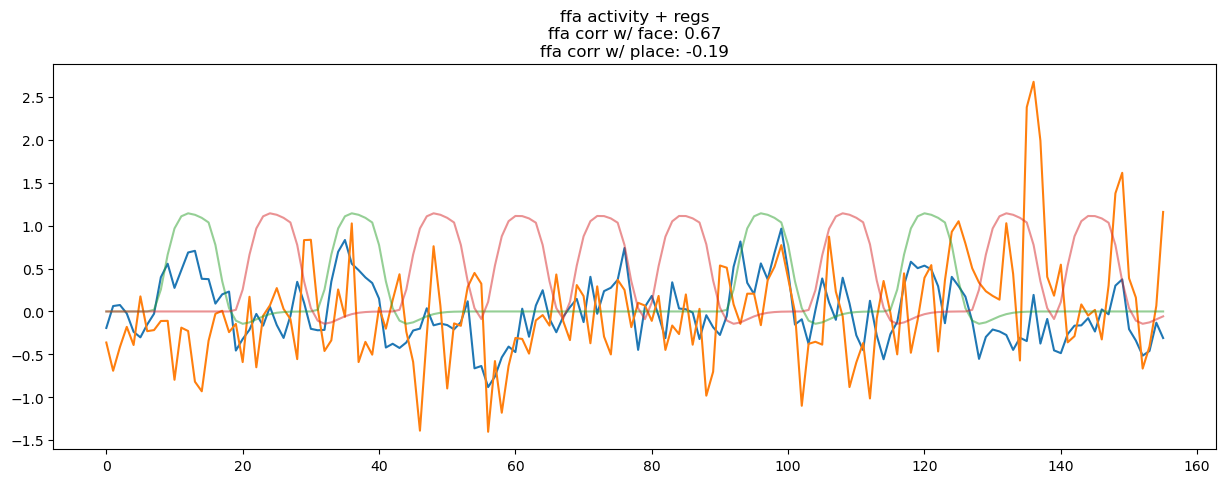

In [146]:
# Task regressors
from nilearn.glm.first_level import make_first_level_design_matrix
import pandas as pd

events_fn = f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv'
events = pd.read_csv(events_fn,delimiter='\t')

t_r = 2.0 
n_scans = epi_flat.shape[1]  # the acquisition comprises 128 scans
frame_times = (np.arange(n_scans) * t_r)

design_matrix = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

face_reg = design_matrix[['face','body']].values.sum(axis=1)
place_reg = design_matrix[['house', 'object', 'scene', 'scramble']].values.sum(axis=1)

ffa_im = ants.image_read(f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz')
func_ffa = func_gm[ffa_im.numpy().flatten()[gm_flat==1]==1,:]
ffa_scaler = utils.Scaler(func_ffa)
ffa_list = ffa_scaler.transform(func_ffa)
ffa_coords = torch.from_numpy(gm_coords[ffa_im.numpy().flatten()[gm_flat==1]==1,:])

plt.figure(figsize=(15,5))
plt.plot(ffa_list[:,:].mean(axis=0))
plt.plot(func_cf.mean(axis=0)-func_cf.mean(axis=0).mean())
plt.plot(face_reg,alpha=.5)
plt.plot(place_reg,alpha=.5)
plt.title('ffa activity + regs\n'+'ffa corr w/ face: {:.2f}\nffa corr w/ place: {:.2f}'.format(np.corrcoef(ffa_list[:,:].mean(axis=0),face_reg)[0,1],np.corrcoef(ffa_list[:,:].mean(axis=0),place_reg)[0,1]))

In [147]:
ffa_list.shape

(58, 156)

In [148]:
# Correlation between FFA AVG and regressors before denoising
(np.corrcoef(func_ffa.mean(axis=0),face_reg)[0,1],
np.corrcoef(func_ffa.mean(axis=0),place_reg)[0,1],)

(0.6265776697426783, -0.20437710027115752)

In [149]:
# Same thing, but correlate with every voxel first and then average the correlations. 
(np.array([np.corrcoef(func_ffa[v,:],face_reg)[0,1] for v in range(func_ffa.shape[0])]).mean(),
np.array([np.corrcoef(func_ffa[v,:],place_reg)[0,1] for v in range(func_ffa.shape[0])]).mean(),)

(0.23765441692530917, -0.0685568901420259)

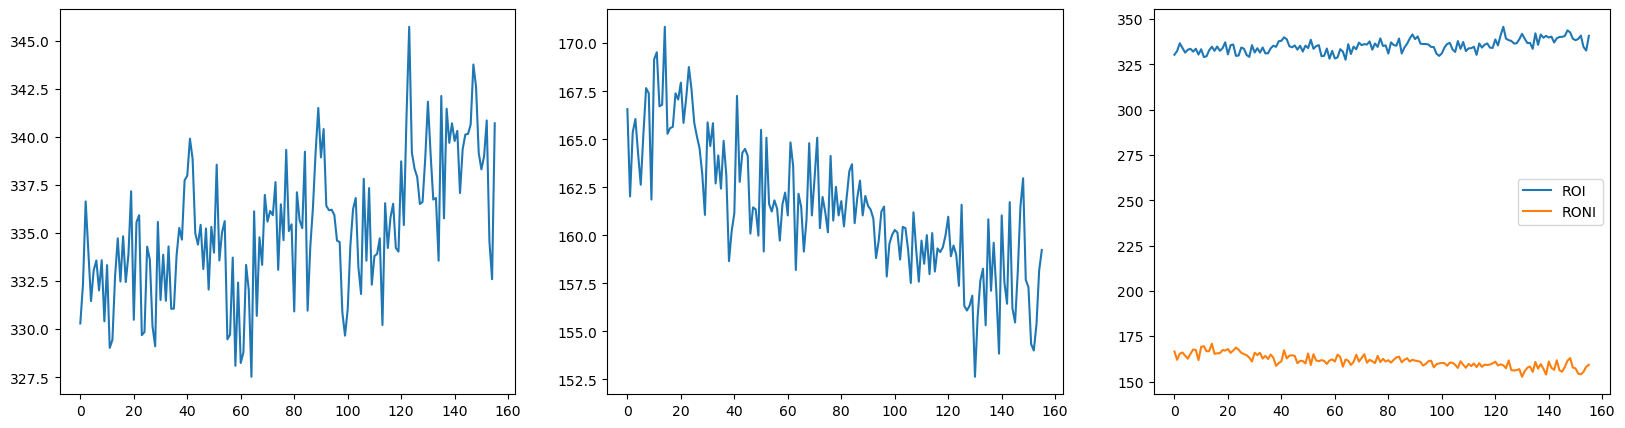

In [150]:
# Plot first voxel in ROI, RONI and both
plt.figure(figsize=(20,5))
plt.subplot(1,3,1);plt.plot(func_gm[0,:])
plt.subplot(1,3,2);plt.plot(func_cf[0,:])
plt.subplot(1,3,3);plt.plot(func_gm[0,:]);plt.plot(func_cf[0,:]);plt.legend(['ROI','RONI'])

In [151]:
print(func_gm.shape)
print(func_cf.shape)

(44212, 156)
(9519, 156)


In [152]:
#Normalization of Data, remove voxels with std of 0 so it doesnt crash CVAE (from Yu Zhu's code)
func_gm, gm_coords = utils.remove_std0_coords(func_gm,gm_coords)
# func_gm = utils.remove_std0(func_gm)
func_cf = utils.remove_std0(func_cf)
print(func_gm.shape)
print(func_cf.shape)

(40867, 156)
(9096, 156)


In [153]:
len(gm_coords)

40867

In [154]:
# Apply scaler to ROI and RONI
obs_scale = utils.Scaler(func_gm)
obs_list = obs_scale.transform(func_gm)
print(obs_list.shape)
noi_scale = utils.Scaler(func_cf)
noi_list = noi_scale.transform(func_cf)
print(noi_list.shape)

(40867, 156)
(9096, 156)


In [155]:
obs_aug = np.concatenate((obs_list,np.repeat(ffa_list,100,axis=0)),axis=0)

In [156]:
print(gm_coords.shape)
print(obs_list.shape)
print(noi_list.shape)

(40867, 3)
(40867, 156)
(9096, 156)


In [157]:
gm_coords = gm_coords[obs_list.std(axis=-1)!=0.0,:]
obs_list = obs_list[obs_list.std(axis=-1)!=0.0,:]
noi_list = noi_list[noi_list.std(axis=-1)!=0.0,:]

In [158]:
print(gm_coords.shape)
print(obs_list.shape)
print(noi_list.shape)

(40867, 3)
(40867, 156)
(9096, 156)


In [159]:
len(obs_list)

40867

In [160]:
len(obs_aug)

46667

In [161]:
print(obs_list.shape)
print(noi_list.shape)
if obs_list.shape[0]>noi_list.shape[0]:
    n_pad = obs_list.shape[0]-noi_list.shape[0]
    pad_idx = np.random.randint(low=0,high=noi_list.shape[0],size=n_pad)
    noi_list = np.concatenate([noi_list,np.array([noi_list[i,:] for i in pad_idx])])
    print(obs_list.shape)
    print(noi_list.shape)

(40867, 156)
(9096, 156)
(40867, 156)
(40867, 156)


In [162]:
#pca = PCA(n_components = 20)

In [163]:
#pca.fit(obs_list)

In [164]:
#obs_dimred = pca.fit_transform(obs_list)

In [165]:
#obs_dimred.shape

In [166]:
# %%time
# # Fit GMM
# gmm = GaussianMixture(n_components=20)
# gmm.fit(obs_dimred)

In [167]:
#log_prob = gmm.score_samples(pca.transform(obs_list[0:2]).reshape(2, -1))

In [168]:
#print(-log_prob)

(array([7.600000e+01, 6.804000e+03, 8.723870e+05, 4.223613e+06,
        1.251288e+06, 2.093600e+04, 1.230000e+02, 0.000000e+00,
        1.000000e+01, 1.500000e+01]),
 array([-6.8895464, -4.9556017, -3.021657 , -1.0877123,  0.8462324,
         2.780177 ,  4.714122 ,  6.6480665,  8.582011 , 10.515956 ,
        12.449901 ], dtype=float32),
 <BarContainer object of 10 artists>)

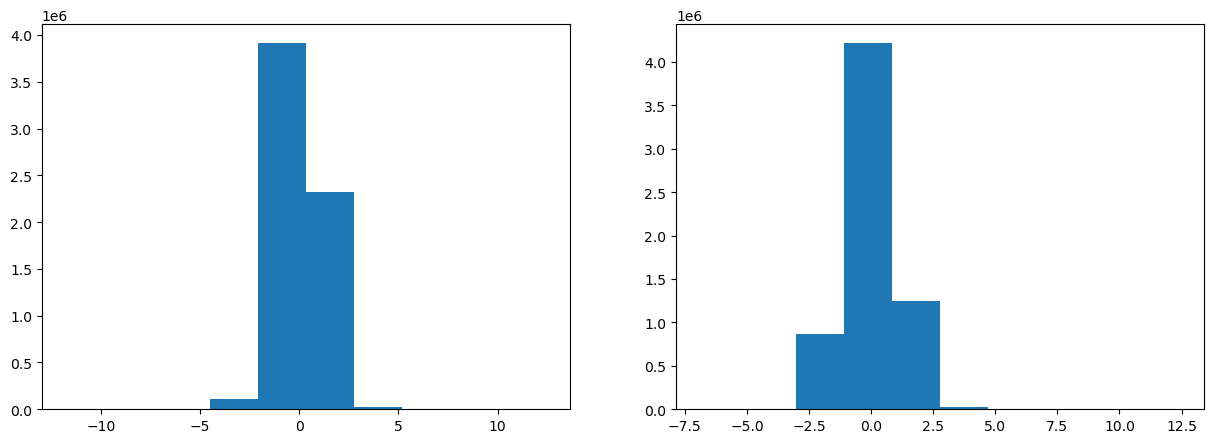

In [169]:
# Plot histograms for ROI and RONI
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(obs_list.flatten())
plt.subplot(1,2,2)
plt.hist(noi_list.flatten())

In [170]:
min_obs_list = obs_list.min()
max_obs_list = obs_list.max()

min_noi_list = noi_list.min()
max_noi_list = noi_list.max()

In [171]:
# Optiomal, additionaly norm the inputs to be 0-1
do_norm = False
if do_norm==True:
    obs_list = utils.norm(obs_list)
    noi_list = utils.norm(noi_list)

In [172]:
from nilearn.glm.first_level import make_first_level_design_matrix
import pandas as pd

events_fn = f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv'
events = pd.read_csv(events_fn,delimiter='\t')

t_r = 2.0 
n_scans = epi_flat.shape[1]  # the acquisition comprises 128 scans
frame_times = (np.arange(n_scans) * t_r)

X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

## Plotting functions

In [173]:
def get_betas(ffa_batch):
    # Calculates betas for different regressors
    Y = ffa_batch
    do_norm=True # This is important, incase DeepCor scales the signal, we dont want the betas to be artificailly inflated
    if do_norm==True:
        Y = Y-Y.mean(axis=1)[:,np.newaxis]
        Y = Y/Y.std(axis=1)[:,np.newaxis]
    Y = Y.T
    X = X1.values # Regressor information 
    beta = np.linalg.inv(X.T @ X1) @ X1.T @ Y
    beta = beta.T
    return beta
    
def get_contrast(ffa_fg):
    # Calculates face+body > house+scene+object+scramble
    beta = get_betas(ffa_fg).values
    contrast_vector = np.array([2,2,-1,-1,-1,-1,0,0,0,0])
    contrast_values = beta @ contrast_vector
    return contrast_values.mean()

def plot_contrast():
    plt.figure()
    ffa_batch = ffa_list[0:batch_size,:]
    ffa_batch = torch.tensor(ffa_batch[:,:]).to(device)
    
    ffa_tensor = ffa_batch.unsqueeze(1)
    coords_tensor = ffa_coords.unsqueeze(2)
    coords_tensor = coords_tensor.repeat(1,1,ffa_tensor.shape[2])
    observation = torch.cat((ffa_tensor,coords_tensor.to(device)),axis=1)
    min_val = torch.min(observation[0,:])
    max_val = torch.max(observation[0,:])
    observation[0,:] = (observation[0,:]-min_val)/(max_val-min_val)
    
    signal,noise = model.forward(observation.to(device))
    signal = signal.detach().cpu().numpy()[:,:epi.shape[-1]]
    noise = noise.detach().cpu().numpy()[:,:epi.shape[-1]]
    
    conf_pcs = PCA(n_components=5).fit_transform(epi_flat[cf_flat==1,:].transpose())
    conf_pcs.shape
    
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(conf_pcs,ffa_list.transpose());
    ffa_compcorr = ffa_list.transpose()-lin_reg.predict(conf_pcs)
    ffa_compcorr = ffa_compcorr.transpose()
    
    contrast_vals = [get_contrast(ffa_list),
        get_contrast(ffa_compcorr),
        get_contrast(signal),
        get_contrast(noise)]
    
    plt.bar(np.arange(len(contrast_vals)),contrast_vals);
    plt.title('face selectivity contrast');
    #plt.xticks([0,1,2,3],['RAW','COMPCOR','SIGNAL','NOISE']);
    plt.xticks([0,1,2,3],[f'RAW\n{contrast_vals[0]:.2f}',f'COMPCOR\n{contrast_vals[1]:.2f}',f'SIGNAL\n{contrast_vals[2]:.2f}',f'NOISE\n{contrast_vals[3]:.2f}'])

In [174]:
 def get_batches(data, batch_size):
    n = data.shape[0]
    for start in range(0, n, batch_size):
        yield data[start: start + batch_size]    

In [175]:
def save_derivs(weights_ofn):
    model.eval()
    import pickle

    ffa_batch = ffa_list[0:batch_size,:]
    ffa_batch = torch.tensor(ffa_batch[:,:]).to(device)
    
    ffa_tensor = ffa_batch.unsqueeze(1)
    coords_tensor = ffa_coords.unsqueeze(2)
    coords_tensor = coords_tensor.repeat(1,1,ffa_tensor.shape[2])
    observation = torch.cat((ffa_tensor,coords_tensor.to(device)),axis=1)
    min_val = torch.min(observation[0,:])
    max_val = torch.max(observation[0,:])
    observation[0,:] = (observation[0,:]-min_val)/(max_val-min_val)
    
    signal,noise = model.forward(observation.to(device))
    
    signal = signal.detach().cpu().numpy()[:,:epi.shape[-1]]
    noise = noise.detach().cpu().numpy()[:,:epi.shape[-1]]
    
    conf_pcs = PCA(n_components=5).fit_transform(epi_flat[cf_flat==1,:].transpose())
    conf_pcs.shape
    
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(conf_pcs,ffa_list.transpose());
    ffa_compcorr = ffa_list.transpose()-lin_reg.predict(conf_pcs)
    ffa_compcorr = ffa_compcorr.transpose()
    
    contrast_vals = [get_contrast(ffa_list),
        get_contrast(ffa_compcorr),
        get_contrast(signal),
        get_contrast(noise)]
    
    
    corr2face = [np.corrcoef(ffa_list.mean(axis=0),face_reg)[0,1],
    np.corrcoef(ffa_compcorr.mean(axis=0),face_reg)[0,1],
    np.corrcoef(signal.mean(axis=0),face_reg)[0,1],
    np.corrcoef(noise.mean(axis=0),face_reg)[0,1],]
    
    corr2place = [np.corrcoef(ffa_list.mean(axis=0),place_reg)[0,1],
    np.corrcoef(ffa_compcorr.mean(axis=0),place_reg)[0,1],
    np.corrcoef(signal.mean(axis=0),place_reg)[0,1],
    np.corrcoef(noise.mean(axis=0),place_reg)[0,1],]
    
    derivs = {
        'ffa_list' : ffa_list,
        'signal' :signal ,
        'noise' : noise,
        'conf_pcs' : conf_pcs,
        'face_reg' : face_reg,
        'place_reg' : place_reg,
        'contrast_vals' : contrast_vals,
        'corr2face' : corr2face,
        'corr2place' : corr2place,}
    
    derivs_ofn = weights_ofn.replace('.weights','.pickle')
    with open(derivs_ofn, 'wb') as handle:
        pickle.dump(derivs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'saved as: {derivs_ofn}')

   
    coords_cast = np.concatenate([gm_coords[:,:,np.newaxis] for _ in range(obs_list.shape[-1])],axis=-1)
    use_obs_list = np.concatenate([obs_list[:,np.newaxis,:],coords_cast],axis=1)
    
    brain_signals=[]
    gm_batches = list(get_batches(use_obs_list, batch_size))
    
    for gm_batch in gm_batches:
        gm_batch = torch.from_numpy(gm_batch).float().to(device)
        brain_signals.append( model.forward(gm_batch)[0][:,0:epi.shape[-1]].detach().cpu().numpy() )
    
    brain_arr = np.zeros(epi.numpy().shape)
    std0 = epi.numpy().std(axis=-1)<1e-3
    brain_arr[(gm.numpy()==1) * (std0==False)] = np.vstack(brain_signals)
    denoised_im = epi.new_image_like(brain_arr)
    denoised_im.to_filename(weights_ofn.replace('.weights','.nii.gz'))
    model.train()

# Training the network

In [176]:
n_epochs = 100
batch_size = 1024

### Conv denoiser

In [177]:
torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2conv(obs_list,noi_list,gm_coords)
#train_inputs = TrainDataset_coords2conv(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
conv_dir = f'conv-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(conv_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/conv_coords',conv_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Conv1Ddenoise(input_channels = 4)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

conv-sub-02-R2-T-2025_07_28_17_39_21


In [178]:
dataloader_iter_in = iter(train_in)
inputs_gm,inputs_cf,coords = next(dataloader_iter_in)

In [183]:
inputs_gm.shape

torch.Size([1024, 4, 156])

In [184]:
inputs_cf.shape

torch.Size([1024, 156])

In [179]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [sig, noise] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss = loss_ncc+loss_mse
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L
weights_ofn = f'../Data/StudyForrest/conv_coords/{conv_dir}/conv_denoise-{sub}.weights'
torch.save(model.state_dict(),weights_ofn)
save_derivs(weights_ofn)

 29%|████████████▏                             | 29/100 [00:54<02:12,  1.87s/it]


KeyboardInterrupt: 

In [ ]:
dashboard.adversarial_losses(track)

In [ ]:
dashboard.adversarial_ffa_coords2_conv(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords)

In [ ]:
plot_contrast()

### Train longer

In [ ]:
#n_epochs = 1000
for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [sig, noise] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss = loss_ncc+loss_mse
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

weights_ofn = f'../Data/StudyForrest/conv_coords/{conv_dir}/conv_denoise500-{sub}.weights'
torch.save(model.state_dict(),weights_ofn)
save_derivs(weights_ofn)

In [ ]:
dashboard.adversarial_losses(track)

In [ ]:
dashboard.adversarial_ffa_coords2_conv(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords)

In [ ]:
plot_contrast()

### Conv denoiser with batchnorm

In [ ]:
# n_epochs = 1000
# batch_size = 1024

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2conv(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
conv_dir = f'conv-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(conv_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/conv_coords',conv_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Conv1DdenoiseBN(input_channels = 4)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [ ]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [sig, noise] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss = loss_ncc+loss_mse
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

weights_ofn = f'../Data/StudyForrest/conv_coords/{conv_dir}/conv_denoise_bn-{sub}.weights'
torch.save(model.state_dict(),weights_ofn)
save_derivs(weights_ofn)

In [ ]:
dashboard.adversarial_losses(track)

In [ ]:
dashboard.adversarial_ffa_coords2_conv(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords)

In [ ]:
plot_contrast()

### Larger conv denoiser

In [ ]:
# n_epochs = 1000
# batch_size = 1024

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2conv(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
conv_dir = f'conv-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(conv_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/conv_coords',conv_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Conv1Ddenoise_large(input_channels = 4)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [ ]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [sig, noise] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss = loss_ncc+loss_mse
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

weights_ofn = f'../Data/StudyForrest/conv_coords/{conv_dir}/conv_denoise_large-{sub}.weights'
torch.save(model.state_dict(),weights_ofn)
save_derivs(weights_ofn)

In [ ]:
dashboard.adversarial_losses(track)

In [ ]:
dashboard.adversarial_ffa_coords2_conv(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords)

In [ ]:
plot_contrast()

### Train longer

In [ ]:
#n_epochs = 1000
for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [sig, noise] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss = loss_ncc+loss_mse
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

weights_ofn = f'../Data/StudyForrest/conv_coords/{conv_dir}/conv_denoise_large500-{sub}.weights'
torch.save(model.state_dict(),weights_ofn)
save_derivs(weights_ofn)

In [ ]:
dashboard.adversarial_losses(track)

In [ ]:
dashboard.adversarial_ffa_coords2_conv(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords)

In [ ]:
plot_contrast()

### Conv denoiser with smoothness loss

In [ ]:
# n_epochs = 1000
# batch_size = 1024

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2conv(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
conv_dir = f'conv-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(conv_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/conv_coords',conv_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Conv1Ddenoise(input_channels = 4)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [ ]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [sig, noise] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        smoothness_loss = model.smoothness_loss(sig[:,0:epi.shape[-1]])
        loss = loss_ncc+loss_mse+0.01*smoothness_loss
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

weights_ofn = f'../Data/StudyForrest/conv_coords/{conv_dir}/conv_smooth-{sub}.weights'
torch.save(model.state_dict(),weights_ofn)
save_derivs(weights_ofn)

In [ ]:
dashboard.adversarial_losses(track)

In [ ]:
dashboard.adversarial_ffa_coords2_conv(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords)

In [ ]:
plot_contrast()

### Smaller amount of smoothness

In [ ]:
# n_epochs = 1000
# batch_size = 1024

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2conv(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
conv_dir = f'conv-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(conv_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/conv_coords',conv_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Conv1Ddenoise(input_channels = 4)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [ ]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [sig, noise] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        smoothness_loss = model.smoothness_loss(sig[:,0:epi.shape[-1]])
        loss = loss_ncc+loss_mse+0.0001*smoothness_loss
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

weights_ofn = f'../Data/StudyForrest/conv_coords/{conv_dir}/conv_smooth-small-{sub}.weights'
torch.save(model.state_dict(),weights_ofn)
save_derivs(weights_ofn)

In [ ]:
dashboard.adversarial_losses(track)

In [ ]:
dashboard.adversarial_ffa_coords2_conv(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords)

In [ ]:
plot_contrast()

### Unet denoiser

In [ ]:
# n_epochs = 1000
# batch_size = 1024

torch.cuda.empty_cache()
torch.cuda.init()

# Dataset
train_inputs = datasets.TrainDataset_coords2conv(obs_list,noi_list,gm_coords)

# Dataloader
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                                 shuffle=True, num_workers=1,drop_last=True)

# Output folder

timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
conv_dir = f'conv-{sub}-R{r}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
print(conv_dir)
utils.safe_mkdir(os.path.join('../Data/StudyForrest/conv_coords',conv_dir)) # Makes the directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = models.Conv1DUnet_denoise(input_channels = 4)   # need to add the last layer to rebuild the original size
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [ ]:
track = {}
loss_L = []
loss_signal_L = []
loss_noise_L = []
track['face_reg'] = face_reg
for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [sig, noise] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss = loss_ncc+loss_mse
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

weights_ofn = f'../Data/StudyForrest/conv_coords/{conv_dir}/conv_weights_unet_denoise-{sub}.weights'
torch.save(model.state_dict(),weights_ofn)
save_derivs(weights_ofn)

In [ ]:
dashboard.adversarial_losses(track)

In [ ]:
dashboard.adversarial_ffa_coords2_conv(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords)

In [ ]:
plot_contrast()

### Train longer

In [ ]:
#n_epochs = 1000
for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times    
    dataloader_iter_in = iter(train_in)
    running_loss = 0
    running_loss_signal = 0
    running_loss_noise = 0
    for i in range(len(train_in)):           
        optimizer.zero_grad()
        inputs_gm,inputs_cf,coords = next(dataloader_iter_in)
        inputs_gm = inputs_gm.float().to(device)
        inputs_cf = inputs_cf.float().to(device)
        coords = coords.float().to(device)
        [sig, noise] = model.forward(inputs_gm)
        #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
        loss_ncc,loss_signal_ncc,loss_noise_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss_mse,loss_signal_mse,loss_noise_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:epi.shape[-1]],noise[:,0:epi.shape[-1]])
        loss = loss_ncc+loss_mse
        loss_signal = loss_signal_ncc+loss_signal_mse
        loss_noise = loss_noise_ncc+loss_noise_mse
        if np.isnan(loss.detach().cpu().numpy()):
            print('loss is NaN')
            break
        loss.backward()
        optimizer.step()
        running_loss += loss
        running_loss_signal += loss_signal
        running_loss_noise += loss_noise        
    epoch_loss = running_loss / len(train_in)
    epoch_loss_signal = running_loss_signal / len(train_in)
    epoch_loss_noise = running_loss_noise / len(train_in)
    loss_L.append(epoch_loss.detach().cpu().numpy())
    loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
    loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
    track['loss_L'] = loss_L
    track['loss_signal_L'] = loss_signal_L
    track['loss_noise_L'] = loss_noise_L

weights_ofn = f'../Data/StudyForrest/conv_coords/{conv_dir}/conv_weights_unet_denoise500-{sub}.weights'
torch.save(model.state_dict(),weights_ofn)
save_derivs(weights_ofn)

In [ ]:
dashboard.adversarial_losses(track)

In [ ]:
dashboard.adversarial_ffa_coords2_conv(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords)

In [ ]:
plot_contrast()

In [ ]:
!date